In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# from warnings import filterwarnings
# filterwarnings(action='ignore')

In [1]:
%matplotlib inline
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from evalys import visu
from evalys.jobset import JobSet

In [23]:
input_location = 'KTH-io-aware'
files_prefix = ''
schedule_names = ['filler', 'backfill-1', 'no-reserve-1', 'fcfs']

In [45]:
schedule_files = []
jobs_files = []
for file in os.listdir('../output/' + input_location):
    if file.endswith('_schedule.csv'):
        schedule_files.append(file)
    elif file.endswith('_jobs.csv'):
        jobs_files.append(file)

schedule_files = [os.path.join('../output', input_location, str(file)) for file in sorted(schedule_files)]
jobs_files = [os.path.join('../output', input_location, str(file)) for file in sorted(jobs_files)]
print(schedule_files)
print(jobs_files)

['../output/KTH-io-aware/backfill-1_schedule.csv', '../output/KTH-io-aware/balance-largest-1_schedule.csv', '../output/KTH-io-aware/balance-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-smallest-1_schedule.csv', '../output/KTH-io-aware/fcfs_schedule.csv', '../output/KTH-io-aware/filler_schedule.csv', '../output/KTH-io-aware/no-reserve-1_schedule.csv']
['../output/KTH-io-aware/backfill-1_jobs.csv', '../output/KTH-io-aware/balance-11-ratio-1_jobs.csv', '../output/KTH-io-aware/balance-largest-1_jobs.csv', '../output/KTH-io-aware/balance-ratio-1_jobs.csv', '../output/KTH-io-aware/balance-smallest-1_jobs.csv', '../output/KTH-io-aware/fcfs_jobs.csv', '../output/KTH-io-aware/filler_jobs.csv', '../output/KTH-io-aware/no-reserve-1_jobs.csv']


In [46]:
metrics = pd.DataFrame()
for file in schedule_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        df = pd.read_csv(file)
        df['schedule'] = schedule_name
        df = df.set_index('schedule')
        metrics = metrics.append(df)

 backfill-1
 fcfs
 filler
 no-reserve-1


In [47]:
jobsets = {}
for file in jobs_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        jobsets[schedule_name] = JobSet.from_csv(file)

 backfill-1
 fcfs
 filler
 no-reserve-1


In [48]:
metrics.index.rename(None, inplace=True)
metrics = metrics.reindex(schedule_names)
sns.set_theme(context='talk', style='whitegrid')
# sns.set_theme(style='whitegrid')

In [49]:
def transform_jobset(schedule):
    df = jobsets[schedule].df
    static_jobs = df[df.final_state == 'REJECTED'].set_index('jobID')
    dynamic_jobs = df[df.final_state != 'REJECTED']
    times = dynamic_jobs.groupby('workload_name').agg({'success': 'min', 'final_state': 'max', 'starting_time': 'min', 'finish_time':'max'}).reset_index()
    times['jobID'] = times.workload_name.apply(lambda s: s.split('%')[1])
    times.set_index('jobID', inplace=True)
    times.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.loc[times.index].drop(['success', 'final_state', 'starting_time', 'finish_time'], axis=1).join(times)
    resources = dynamic_jobs[dynamic_jobs.profile == 'parallel_homogeneous_profile_0'].groupby('workload_name').agg({'allocated_resources': 'first','proc_alloc': 'first'}).reset_index()
    resources['jobID'] = resources.workload_name.apply(lambda s: s.split('%')[1])
    resources.set_index('jobID', inplace=True)
    resources.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.drop(['allocated_resources', 'proc_alloc'], axis=1).join(resources)
    static_jobs['execution_time'] = static_jobs.finish_time - static_jobs.starting_time
    static_jobs['waiting_time'] = static_jobs.starting_time - static_jobs.submission_time
    static_jobs['turnaround_time'] = static_jobs.finish_time - static_jobs.submission_time
    static_jobs['stretch'] = static_jobs.turnaround_time / static_jobs.execution_time
    static_jobs.reset_index(inplace=True)
    return static_jobs

In [50]:
for schedule in schedule_names:
    jobsets[schedule].df = transform_jobset(schedule)

In [51]:
def calculate_compute_utilisation(schedule):
    compute_time = jobsets[schedule].df[['execution_time', 'allocated_resources']].apply(lambda row: row.execution_time * len(row.allocated_resources), axis=1).sum()
    return compute_time / (metrics.loc[schedule].makespan * 96)

def calculate_storage_utilisation(schedule):
    storage_time = jobsets[schedule].df[['execution_time', 'metadata']].apply(lambda row: row.execution_time * row.metadata, axis=1).sum()
    burst_buffer_capacity = 5 * 10**9
    num_burst_buffers = 12
    total_storage_time = metrics.loc[schedule].makespan * num_burst_buffers * burst_buffer_capacity
    return storage_time / total_storage_time

def create_metric_df(metric):
    return pd.concat([jobsets[schedule].df[metric].rename(schedule) for schedule in schedule_names], axis=1)

In [52]:
metrics['compute_utilisation'] = pd.Series({schedule: calculate_compute_utilisation(schedule) for schedule in schedule_names})
metrics['storage_utilisation'] = pd.Series({schedule: calculate_storage_utilisation(schedule) for schedule in schedule_names})

In [53]:
metrics.T

,filler,backfill-1,no-reserve-1,fcfs
batsim_version,4.0.0,4.0.0,4.0.0,4.0.0
consumed_joules,0,0,0,0
makespan,2.88581e+07,2.88052e+07,5.55449e+07,1.38609e+08
max_slowdown,1.00023,1.00024,1.00024,1.00023
max_turnaround_time,22655.2,22655.2,22655.2,22655.2
max_waiting_time,1e-06,1e-06,1e-06,1e-06
mean_slowdown,0.975925,0.975914,0.975917,0.975923
mean_turnaround_time,223.303,223.715,223.251,223.239
mean_waiting_time,0,0,0,0
nb_computing_machines,109,109,109,109


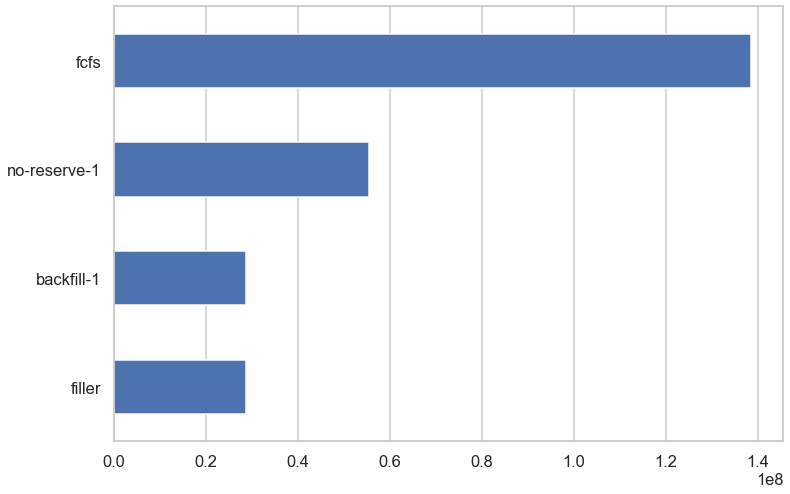

In [35]:
ax = metrics['makespan'].plot.barh(figsize=(12, 8))
ax.grid(axis='y')

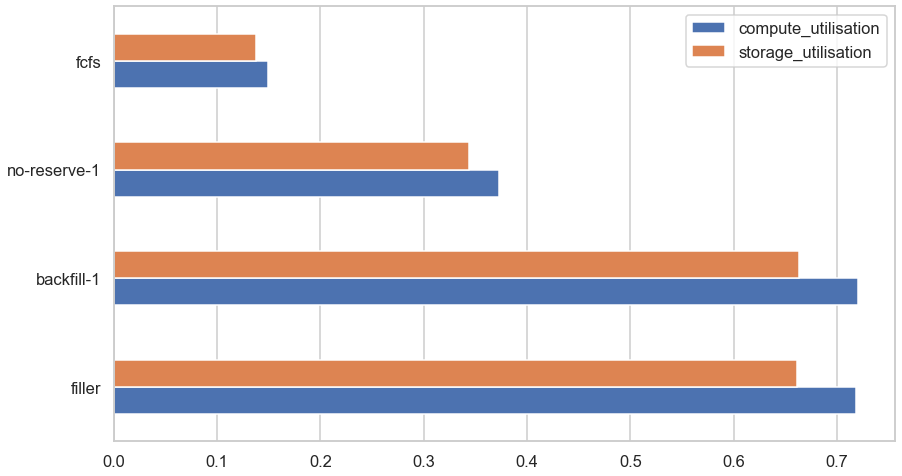

In [36]:
ax = metrics[['compute_utilisation', 'storage_utilisation']].plot.barh(figsize=(14, 8))
ax.grid(axis='y')

In [63]:
waiting_times = create_metric_df('waiting_time')
waiting_times.describe()

,filler,backfill-1,no-reserve-1,fcfs
count,2.845300e+04,28453.000000,2.845300e+04,2.845300e+04
mean,2.125873e+04,15520.974196,7.000104e+06,2.352544e+07
std,1.508317e+05,41939.019186,1.067077e+07,2.938027e+07
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000,1.592272e+05,4.696033e+06
50%,0.000000e+00,193.986644,8.891396e+05,8.883011e+06
75%,5.005819e+03,10839.947901,1.121913e+07,3.206985e+07
max,4.991701e+06,645971.242525,4.330836e+07,1.098763e+08


(0.0, 115370089.32237916)

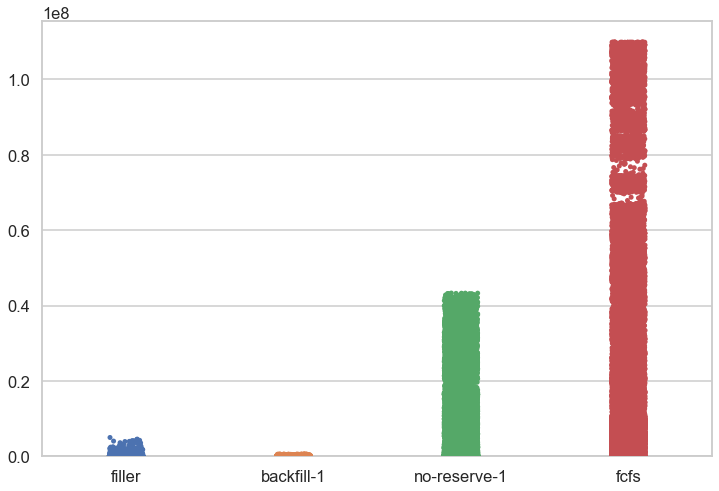

In [60]:
# Scatterplot, outliers
fig, ax = plt.subplots(figsize=(12,8))
sns.stripplot(data=waiting_times, ax=ax)
ax.set_ylim(0)

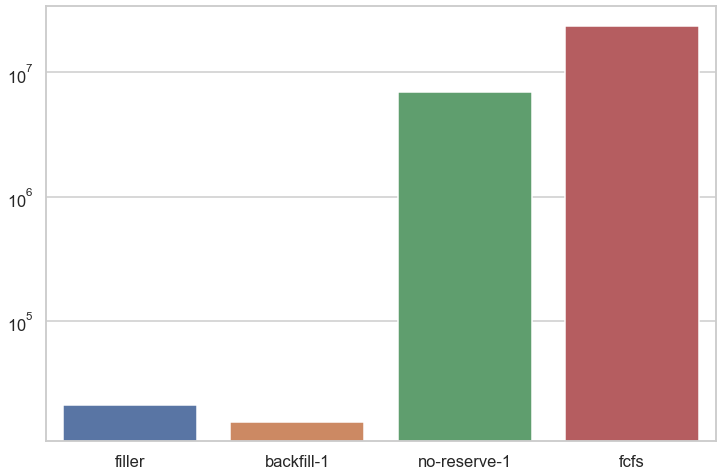

In [61]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=waiting_times, ci=None, ax=ax)
ax.set_yscale('log')
# ax.set_ylim(top=10**7)

(0.0, 29176860.63808005)

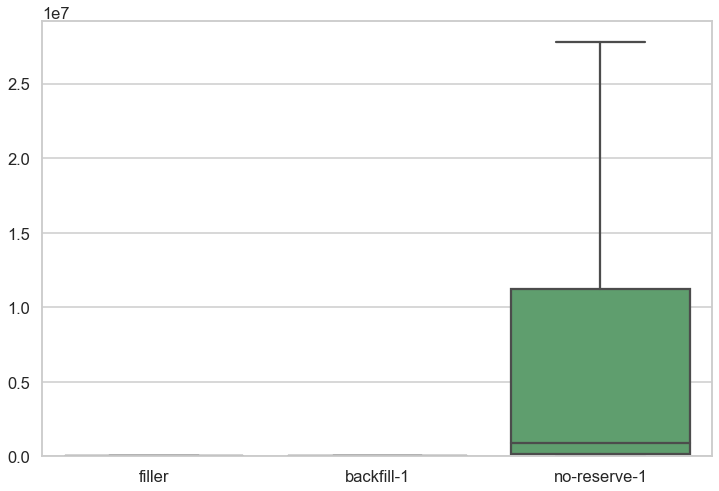

In [62]:
# Standard deviation
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(data=waiting_times.drop(['fcfs'], axis=1), showfliers=False, ax=ax)
ax.set_ylim(0)

In [64]:
turnaround_times = create_metric_df('turnaround_time')
turnaround_times.describe()

,filler,backfill-1,no-reserve-1,fcfs
count,2.845300e+04,28453.000000,2.845300e+04,2.845300e+04
mean,3.004135e+04,24304.985723,7.008885e+06,2.353422e+07
std,1.523364e+05,48783.234383,1.067204e+07,2.938211e+07
min,9.040000e-02,0.127128,4.034460e-01,6.789140e-01
25%,1.690134e+02,225.769969,1.666465e+05,4.704392e+06
50%,5.318302e+03,6712.460699,9.018798e+05,8.885222e+06
75%,2.069844e+04,26197.128503,1.123533e+07,3.207033e+07
max,5.000808e+06,683228.621194,4.331741e+07,1.098809e+08


(0.0, 115374919.31775415)

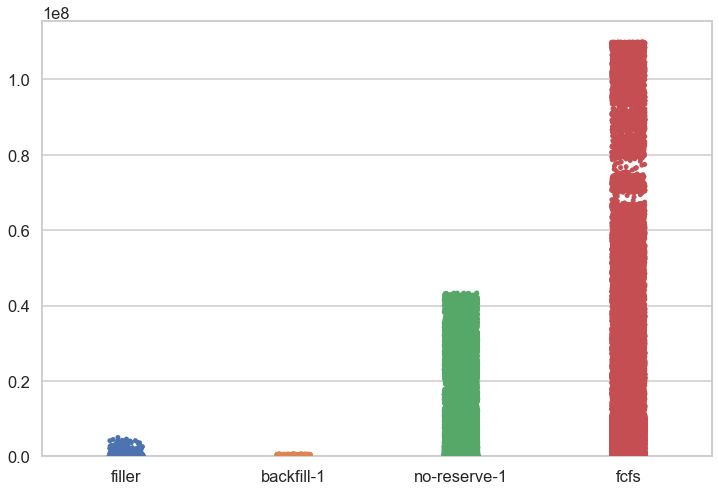

In [65]:
# Scatterplot, outliers
fig, ax = plt.subplots(figsize=(12,8))
sns.stripplot(data=turnaround_times, ax=ax)
ax.set_ylim(0)

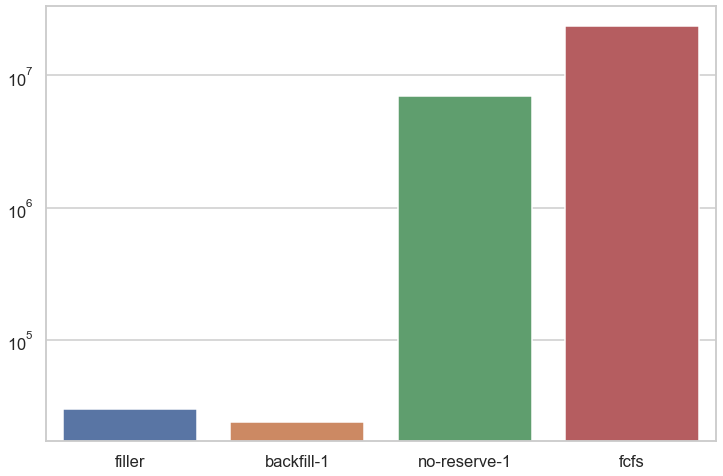

In [66]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=turnaround_times, ci=None, ax=ax)
ax.set_yscale('log')
# ax.set_ylim(top=10**7)

(0.0, 29222943.517733954)

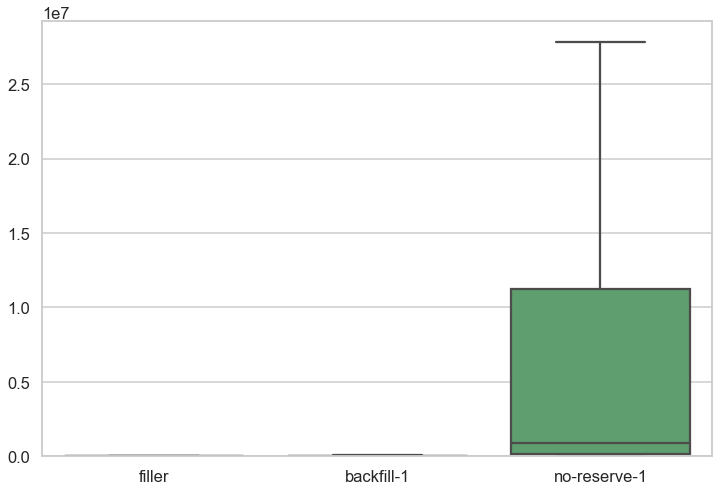

In [67]:
# Standard deviation
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(data=turnaround_times.drop(['fcfs'], axis=1), showfliers=False, ax=ax)
ax.set_ylim(0)

In [68]:
slowdown = create_metric_df('stretch')
slowdown.describe()

,filler,backfill-1,no-reserve-1,fcfs
count,28453.000000,28453.000000,2.845300e+04,2.845300e+04
mean,180.639638,236.261469,1.463346e+05,1.559262e+06
std,1026.405021,1888.031316,5.708875e+05,8.880665e+06
min,1.000000,1.000000,1.000000e+00,1.000000e+00
25%,1.000000,1.000000,7.514007e+01,1.414919e+03
50%,1.000000,1.075853,2.229810e+03,1.434711e+04
75%,5.232060,8.980896,3.955551e+04,4.165467e+05
max,42459.521527,112204.154976,1.959414e+07,7.478350e+08


(0.0, 785226729.4563831)

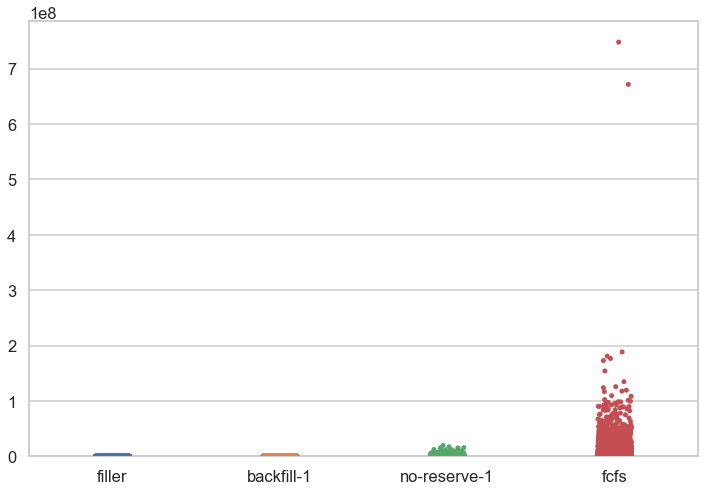

In [69]:
# Scatterplot, outliers
fig, ax = plt.subplots(figsize=(12,8))
sns.stripplot(data=slowdown, ax=ax)
ax.set_ylim(0)

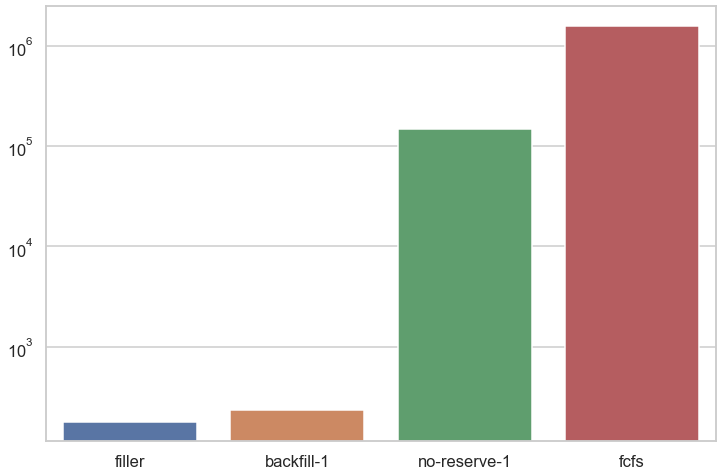

In [70]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=slowdown, ci=None, ax=ax)
ax.set_yscale('log')
# ax.set_ylim(top=10**6)

(0.0, 103711.43979668531)

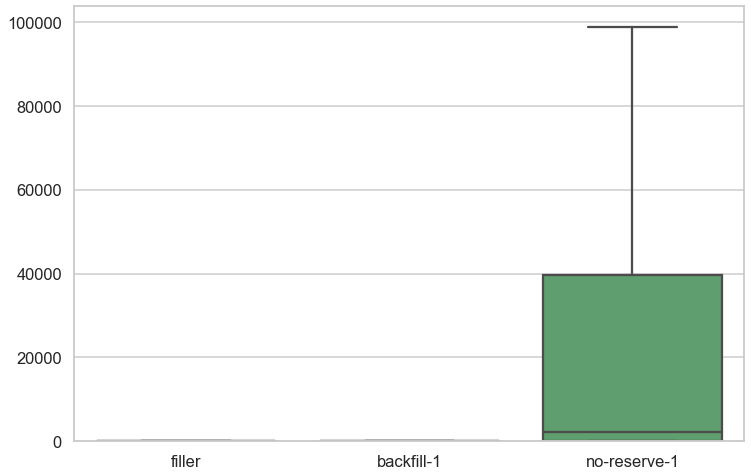

In [71]:
# Standard deviation
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(data=slowdown.drop(['fcfs'], axis=1), showfliers=False, ax=ax)
ax.set_ylim(0)

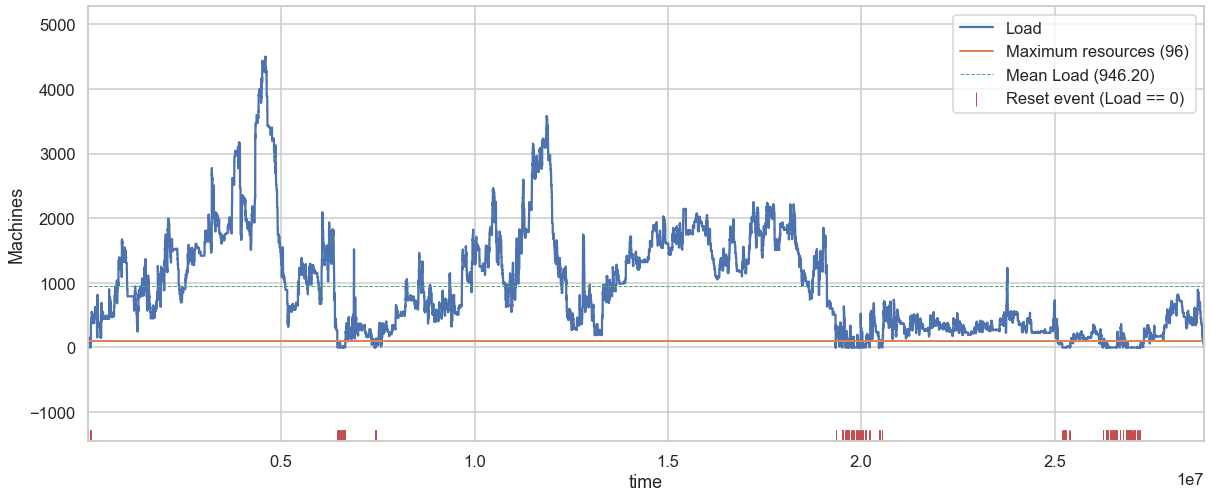

In [54]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['filler'].queue, nb_resources=96, ax=ax)

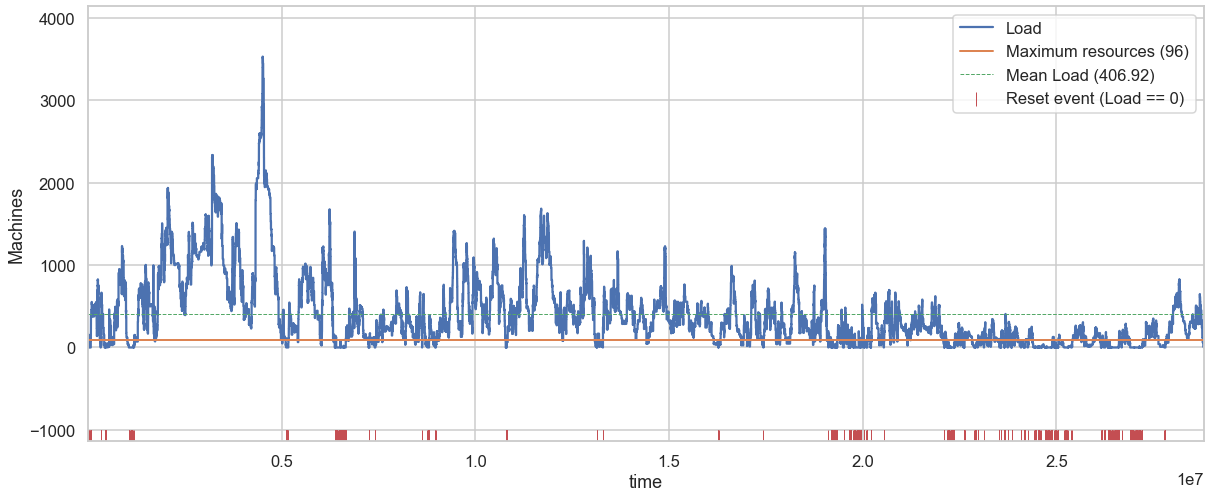

In [55]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['backfill-1'].queue, nb_resources=96, ax=ax)

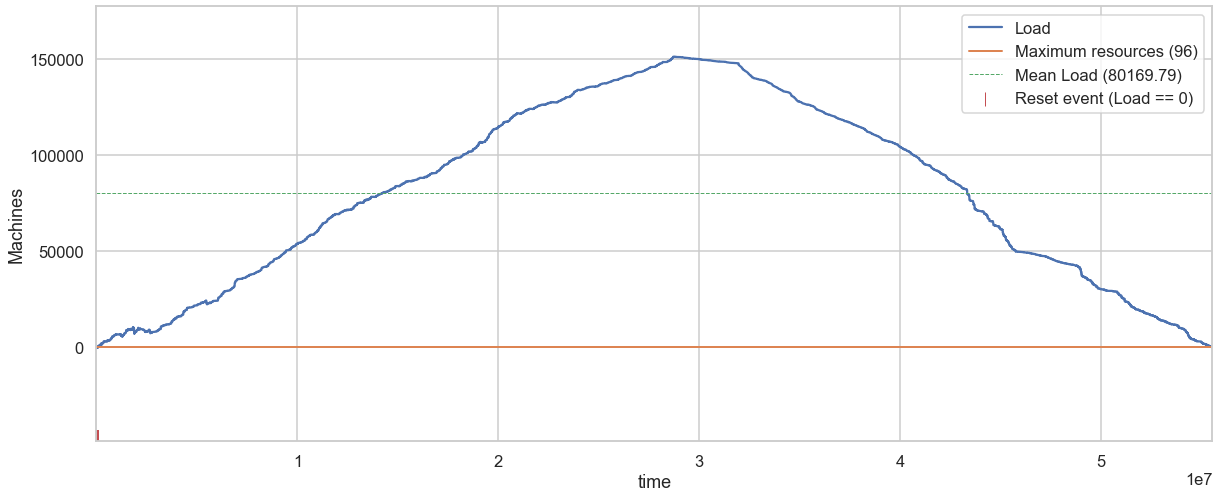

In [56]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['no-reserve-1'].queue, nb_resources=96, ax=ax)

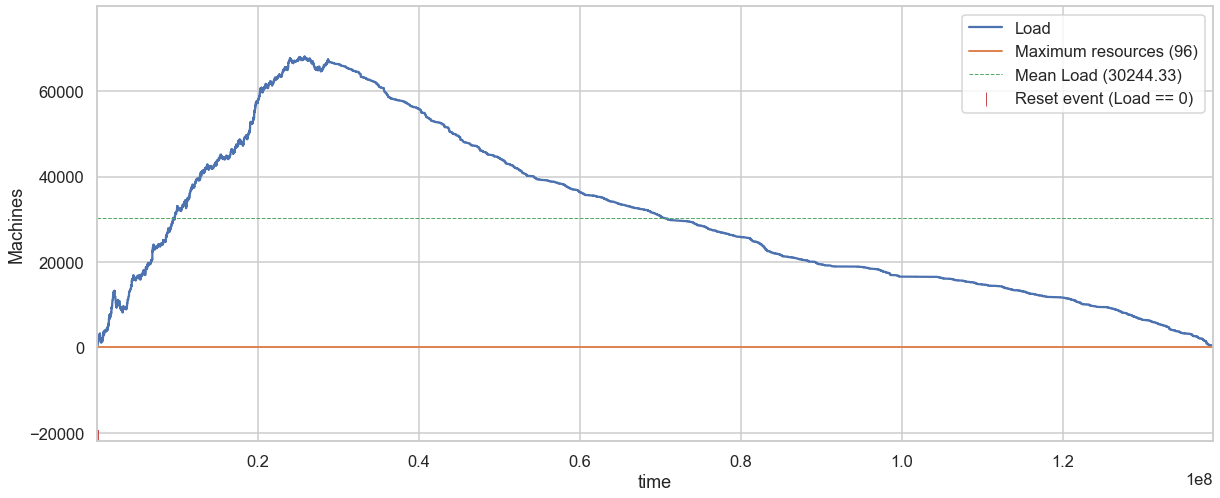

In [57]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['fcfs'].queue, nb_resources=96, ax=ax)